In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
cars = pd.read_csv("C:/Users/woote/Desktop/Python/IBM Machine Learning/Projects/Regression/Car details v3.csv").\
        iloc[:,:-5]

## 2.	Brief description of the data set

In [3]:
cars.dtypes

name             object
year              int64
selling_price     int64
km_driven         int64
fuel             object
seller_type      object
transmission     object
owner            object
dtype: object

In [4]:
cars.describe().round(2)

,year,selling_price,km_driven
count,8128.00,8128.00,8128.00
mean,2013.80,638271.81,69819.51
std,4.04,806253.40,56550.55
min,1983.00,29999.00,1.00
25%,2011.00,254999.00,35000.00
50%,2015.00,450000.00,60000.00
75%,2017.00,675000.00,98000.00
max,2020.00,10000000.00,2360457.00


In [5]:
cars.describe(include = [object])

,name,fuel,seller_type,transmission,owner
count,8128,8128,8128,8128,8128
unique,2058,4,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,129,4402,6766,7078,5289


In [6]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner


## 3.	Brief summary of data exploration and actions taken for data cleaning and feature engineering

There are duplicates

In [7]:
cars.loc[cars.duplicated(keep = False),:].sort_values(['name'])

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
1977,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner
7324,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner
7775,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner
2129,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner
1857,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner
...,...,...,...,...,...,...,...,...
1119,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner
2667,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner
1100,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner
145,Volvo XC40 D4 R-Design,2018,3400000,22000,Diesel,Dealer,Automatic,First Owner


In [8]:
print(cars.shape)
cars = cars.drop_duplicates().reset_index(drop=True)
print(cars.shape)

(8128, 8)
(6925, 8)


Transformations

In [9]:
cars.owner.value_counts()

First Owner             4241
Second Owner            1974
Third Owner              536
Fourth & Above Owner     169
Test Drive Car             5
Name: owner, dtype: int64

In [10]:
cars['owner'] = cars.owner.str.replace(" Owner", "")
cars.owner.value_counts()

First             4241
Second            1974
Third              536
Fourth & Above     169
Test Drive Car       5
Name: owner, dtype: int64

In [11]:
cars['name'] = cars['name'].str.split(" ",1).str[0]
cars['name'].value_counts()


Maruti           2164
Hyundai          1267
Mahindra          723
Tata              647
Honda             362
Ford              361
Toyota            357
Chevrolet         216
Renault           206
Volkswagen        174
Nissan             73
Skoda              70
Datsun             57
BMW                47
Mercedes-Benz      46
Fiat               44
Audi               33
Jeep               22
Mitsubishi         11
Volvo               9
Jaguar              8
Ambassador          4
Force               4
Isuzu               4
MG                  3
Daewoo              3
Kia                 3
Land                3
Lexus               1
Ashok               1
Opel                1
Peugeot             1
Name: name, dtype: int64

C:\Users\woote\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


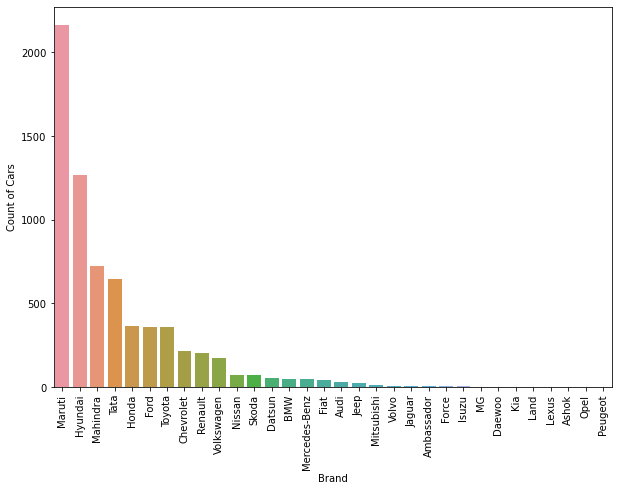

In [12]:
plt.figure(figsize=(10,7))
plt1 = sns.countplot(cars['name'], order=pd.value_counts(cars['name']).index,)
plt1.set(xlabel = 'Brand', ylabel= 'Count of Cars')
plt1.tick_params(axis='x', rotation=90);

Missing Data

In [13]:
cars.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

Outliers

In [14]:
cars.columns.values

array(['name', 'year', 'selling_price', 'km_driven', 'fuel',
       'seller_type', 'transmission', 'owner'], dtype=object)

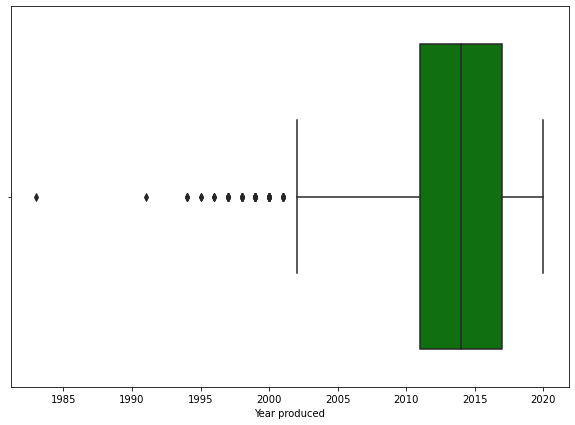

In [15]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(data = cars, x = 'year', color = "green")
ax.set(xlabel='Year produced');

Compare mean prices of cars produced before and after year 2000

In [16]:
mean1 = round(cars.loc[cars.year <= 2000,"selling_price"].mean(),2)
mean2 = round(cars.loc[cars.year > 2000,"selling_price"].mean(),2)
print(mean2/mean1)

6.09575215368069


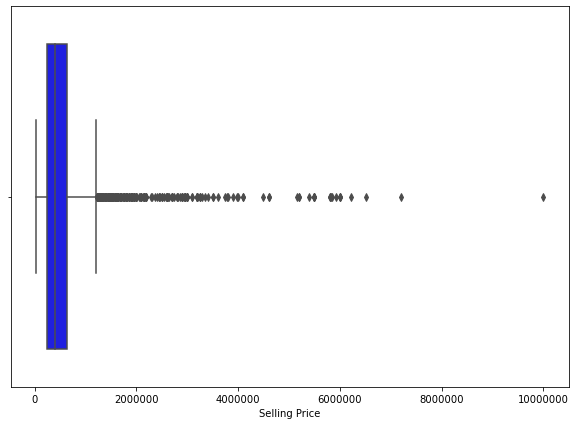

In [17]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(data = cars, x = 'selling_price', color = "blue")
ax.set(xlabel='Selling Price');
ax.ticklabel_format(style='plain', axis='x')

In [18]:
display(cars.loc[cars.selling_price == cars.selling_price.max(),])
cars = cars.loc[cars.selling_price != cars.selling_price.max(),]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
170,Volvo,2017,10000000,30000,Petrol,Individual,Automatic,First


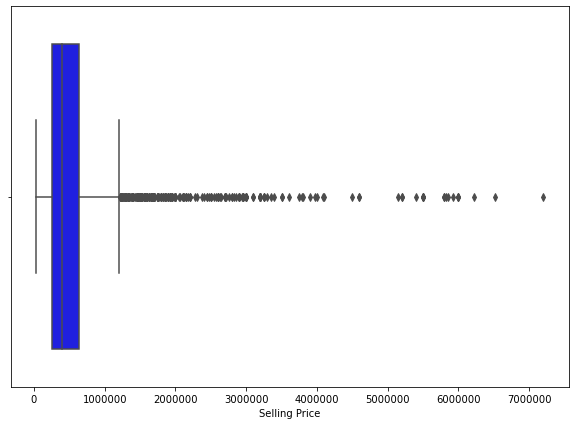

In [19]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(data = cars, x = 'selling_price', color = "blue")
ax.set(xlabel='Selling Price');
ax.ticklabel_format(style='plain', axis='x')

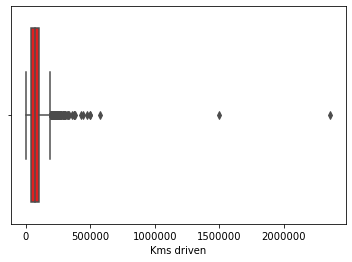

In [20]:
ax = sns.boxplot(data = cars, x = 'km_driven', color = "red")
ax.set(xlabel='Kms driven');
ax.ticklabel_format(style='plain', axis='x')

In [21]:
print(cars.shape)
cars = cars.loc[cars.km_driven <= 1000000,].reset_index(drop=True)
print(cars.shape)

(6924, 8)
(6922, 8)


### TARGET VARIABLE - NORMALITY ASSUMPTION

C:\Users\woote\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


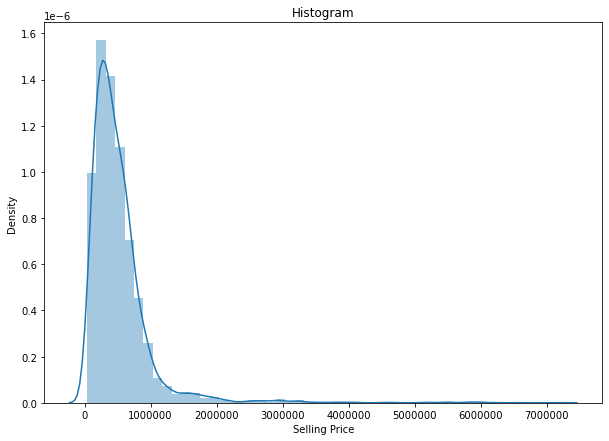

In [22]:
plt.figure(figsize=(10,7))
ax1 = sns.distplot(cars.loc[:,'selling_price'], norm_hist=True)
## Set the title. 
ax1.set_title('Histogram')
ax1.set(xlabel='Selling Price')
ax1.ticklabel_format(style='plain', axis='x');

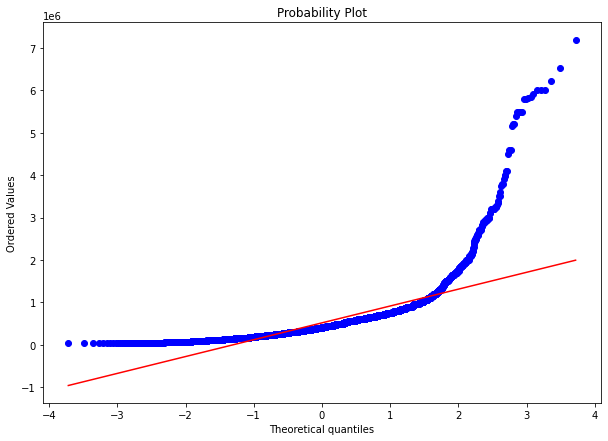

In [23]:
# customizing the QQ_plot. 
plt.figure(figsize=(10,7))
## Set the title. 
ax1.set_title('QQ_plot')
## Plotting the QQ_Plot. 
stats.probplot(cars.loc[:,'selling_price'], plot = plt);

In [24]:
normaltest(cars.selling_price.values)

NormaltestResult(statistic=7102.93049405959, pvalue=0.0)

#### First approach - Log transform

In [25]:
cars['selling_price_log'] = np.log(cars['selling_price'])

C:\Users\woote\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


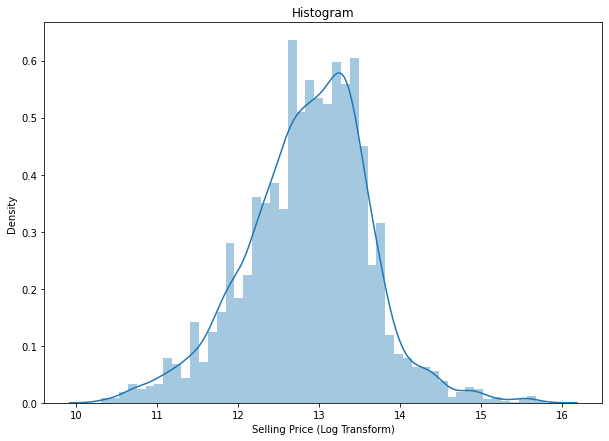

In [26]:
#Histogram
plt.figure(figsize=(10,7))
ax1 = sns.distplot(cars.loc[:,'selling_price_log'], norm_hist=True)
ax1.set_title('Histogram')
ax1.set(xlabel='Selling Price (Log Transform)')
ax1.ticklabel_format(style='plain', axis='x');

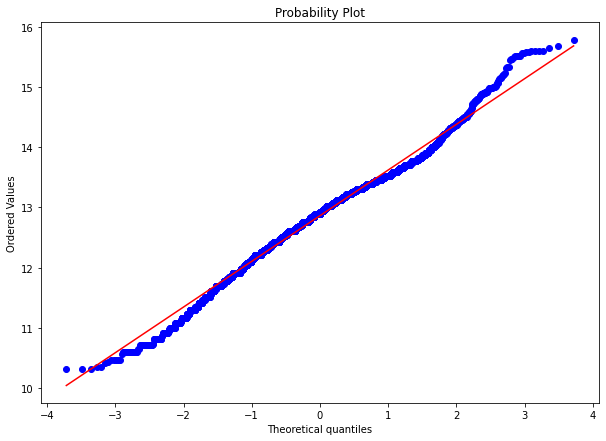

In [27]:
# QQ_plot. 
plt.figure(figsize=(10,7))
stats.probplot(cars.loc[:,'selling_price_log'], plot = plt);

In [28]:
normaltest(cars.selling_price_log.values)

NormaltestResult(statistic=107.48782260618975, pvalue=4.56368736193202e-24)

#### Second approach - Box-Cox transformation

In [29]:
boxcox_tr = boxcox(cars['selling_price'])
cars['selling_price_boxcox'] = boxcox_tr[0]
lambda_bc = boxcox_tr[1]

C:\Users\woote\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


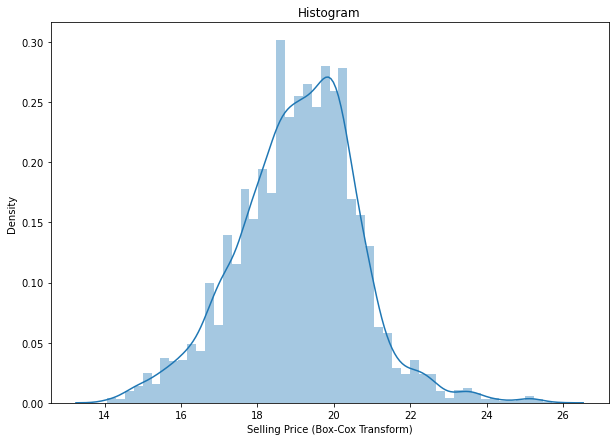

In [30]:
#Histogram
plt.figure(figsize=(10,7))
ax1 = sns.distplot(cars.loc[:,'selling_price_boxcox'], norm_hist=True)
ax1.set_title('Histogram')
ax1.set(xlabel='Selling Price (Box-Cox Transform)')
ax1.ticklabel_format(style='plain', axis='x');

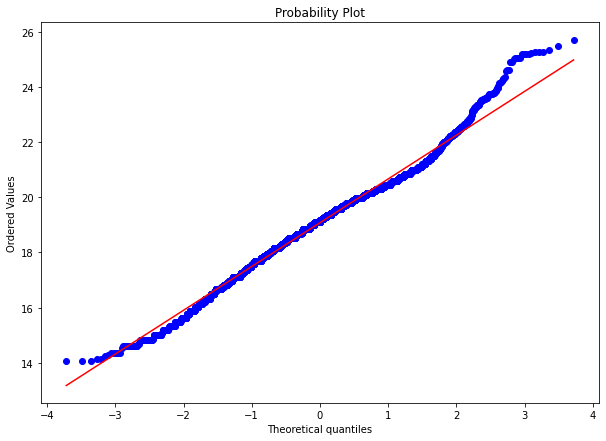

In [31]:
# QQ_plot. 
plt.figure(figsize=(10,7))
stats.probplot(cars.loc[:,'selling_price_boxcox'], plot = plt);

In [32]:
normaltest(cars['selling_price_boxcox'])

NormaltestResult(statistic=93.09344455793112, pvalue=6.0955846054342926e-21)

### Homoscedasticity

In [33]:
#Once again check dtypes
cars.dtypes

name                     object
year                      int64
selling_price             int64
km_driven                 int64
fuel                     object
seller_type              object
transmission             object
owner                    object
selling_price_log       float64
selling_price_boxcox    float64
dtype: object

C:\Users\woote\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


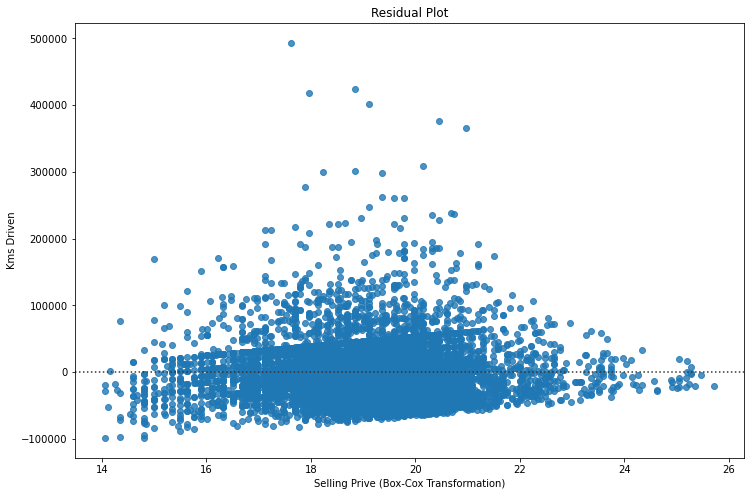

In [34]:
plt.subplots(figsize = (12,8))
ax1 = sns.residplot(cars.selling_price_boxcox, cars.km_driven)
ax1.set_title('Residual Plot')
ax1.set(xlabel='Selling Prive (Box-Cox Transformation)',ylabel = "Kms Driven")
ax1.ticklabel_format(style='plain', axis='y');

### Linearity

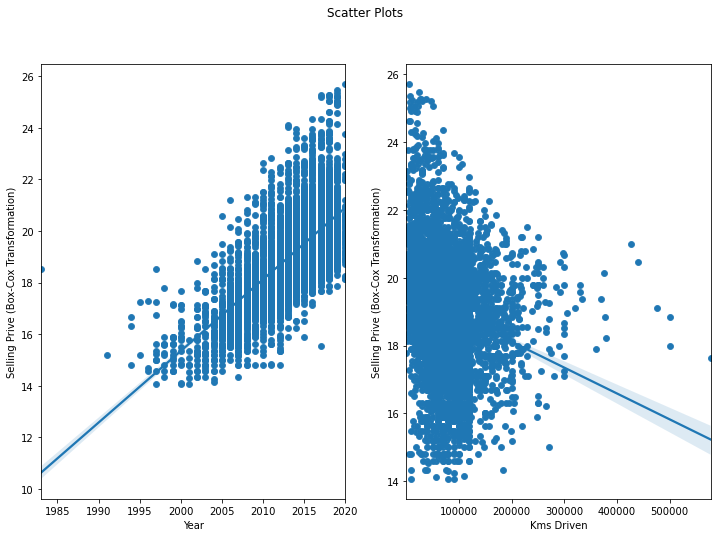

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
sns.scatterplot(x = cars.year, y = cars.selling_price_boxcox,  ax=ax1)
sns.regplot(x = cars.year, y = cars.selling_price_boxcox, ax=ax1)
ax1.set(ylabel='Selling Prive (Box-Cox Transformation)',xlabel = "Year")
 
sns.scatterplot(x = cars.km_driven, y = cars.selling_price_boxcox, ax=ax2)
sns.regplot(x = cars.km_driven, y = cars.selling_price_boxcox, ax=ax2)
ax2.set(ylabel='Selling Prive (Box-Cox Transformation)',xlabel = "Kms Driven")
ax2.ticklabel_format(style='plain', axis='x');
fig.suptitle("Scatter Plots");

### Multicolinearity

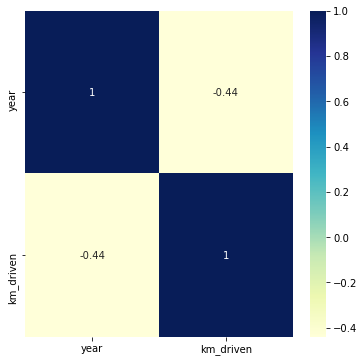

In [36]:
numerical = cars[['year','km_driven']]
plt.figure(figsize = [6,6])
sns.heatmap(data = numerical.corr(), annot = True, cmap = "YlGnBu");

In [37]:
cars.drop(['selling_price','selling_price_log','km_driven','name'],axis = 1,inplace = True)
y = cars['selling_price_boxcox']
x = cars.drop(['selling_price_boxcox'],axis = 1)

In [38]:
categorical_columns=[key for key, value in cars.dtypes.iteritems() if value=='O']
for column in  categorical_columns:
    print("column name:", column)
    print("value_count:")
    print(cars[column].value_counts())

column name: fuel
value_count:
Diesel    3753
Petrol    3075
CNG         56
LPG         38
Name: fuel, dtype: int64
column name: seller_type
value_count:
Individual          6215
Dealer               680
Trustmark Dealer      27
Name: seller_type, dtype: int64
column name: transmission
value_count:
Manual       6339
Automatic     583
Name: transmission, dtype: int64
column name: owner
value_count:
First             4239
Second            1973
Third              536
Fourth & Above     169
Test Drive Car       5
Name: owner, dtype: int64


In [39]:
v_cramer = pd.DataFrame()
results = []
v_cramer["features"] = [a + ' / ' + b for a in categorical_columns for b in categorical_columns if a != b]
for a,b in [(a,b) for a in categorical_columns for b in categorical_columns if a != b]:
    data_crosstab = pd.crosstab(x[a], x[b],margins = False)
    chi2, p, dof, con_table = stats.chi2_contingency(data_crosstab)
    n = data_crosstab.sum().sum()
    dof = min(data_crosstab.shape)-1
    # Calculate Cramer's 
    results.append(np.sqrt(chi2/(n*dof)))
v_cramer['resuls'] = results

In [40]:
print(x.shape)
x = pd.get_dummies(x, prefix=None, prefix_sep='_', drop_first=True)
print(x.shape)

(6922, 5)
(6922, 11)


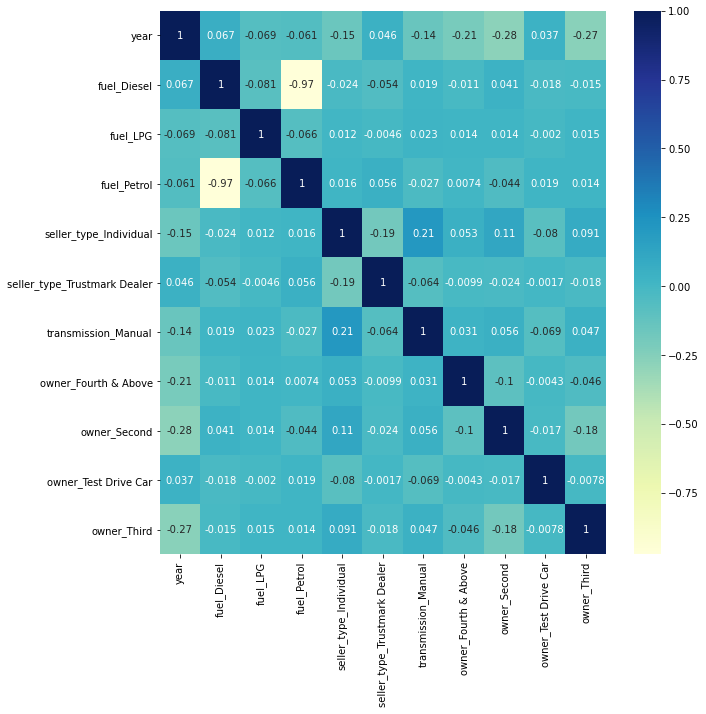

In [41]:
plt.figure(figsize = [10,10])
sns.heatmap(data = x.corr(), annot = True, cmap = "YlGnBu");

In [42]:
v_cramer

,features,resuls
0,fuel / seller_type,0.050539
1,fuel / transmission,0.042713
2,fuel / owner,0.032458
3,seller_type / fuel,0.050539
4,seller_type / transmission,0.211931
5,seller_type / owner,0.136735
6,transmission / fuel,0.042713
7,transmission / seller_type,0.211931
8,transmission / owner,0.112560
9,owner / fuel,0.032458


## MODELLING

In [43]:
x.head()

,year,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above,owner_Second,owner_Test Drive Car,owner_Third
0,2014,1,0,0,1,0,1,0,0,0,0
1,2014,1,0,0,1,0,1,0,1,0,0
2,2006,0,0,1,1,0,1,0,0,0,1
3,2010,1,0,0,1,0,1,0,0,0,0
4,2007,0,0,1,1,0,1,0,0,0,0


In [44]:
y.head().to_frame()

,selling_price_boxcox
0,19.364328
1,18.953103
2,17.218283
3,17.928720
4,16.832405


### Train Test Split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)
print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 2077
number of training samples: 4845


In [493]:
#https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

### Basic LR

In [84]:
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("R^2 on training  data ",lm.score(X_train, y_train))
print("R^2 on testing data ",lm.score(X_test,y_test))

R^2 on training  data  0.6848454115151734
R^2 on testing data  0.6885313515765907


So, arond 68% of variability in the training data is explained by our model
Using the test data  𝑅2 , we get ~0.69

In [85]:
r2_score(y_test.values, predicted)

0.6885313515765907

In [86]:
mse = mean_squared_error(y_true=y_test, y_pred=predicted)
mse

0.8411514008132068

### LR with Polynomial Features

In [128]:
Input_polynomial = [('ss',StandardScaler()),('polynomial', PolynomialFeatures()),('model', LinearRegression())]

param_grid_poly = {
    "polynomial__degree": [1,2,3,4]
}

pipe_poly = Pipeline(Input_polynomial)

search_poly = GridSearchCV(pipe_poly, param_grid_poly, n_jobs=2,return_train_score=True,
                           scoring={"MSE" : 'neg_mean_squared_error',"R2" : 'r2'}, refit = 'R2')

In [129]:
search_poly.fit(X_train, y_train)
search_poly

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('polynomial', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             n_jobs=2, param_grid={'polynomial__degree': [1, 2, 3, 4]},
             refit='R2', return_train_score=True,
             scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [130]:
print("best_score_: ",search_poly.best_score_)
print("best_params_: ",search_poly.best_params_)

best_score_:  0.6817252552351224
best_params_:  {'polynomial__degree': 1}


In [136]:
for i in ['mean_test_R2', 'mean_train_R2', 'mean_test_MSE','params']:
    if i == 'params':
        print(i," : ",search_poly.cv_results_[i])
        continue
    print(i," : ",["{:3f}".format(num) for num in search_poly.cv_results_[i]])

mean_test_R2  :  ['0.681725', '-2555768923705894912.000000', '-10104546002512335863808.000000', '-209737780150191645523968.000000']
mean_train_R2  :  ['0.685151', '0.704829', '0.711442', '0.715518']
mean_test_MSE  :  ['-0.786109', '-6529511969122822144.000000', '-25953774822365033660416.000000', '-538722442127324657745920.000000']
params  :  [{'polynomial__degree': 1}, {'polynomial__degree': 2}, {'polynomial__degree': 3}, {'polynomial__degree': 4}]


### Ridge Regression

In [141]:
Input_ridge = [('ss',StandardScaler()),('polynomial', PolynomialFeatures()),('ridge', Ridge())]

param_grid_ridge = {
    "polynomial__degree": [1,2,3],
    'ridge__alpha': np.geomspace(1, 4, 20)
}

pipe_ridge = Pipeline(Input_ridge)

search_ridge = GridSearchCV(pipe_ridge, param_grid_ridge, n_jobs=2,return_train_score=True,
                           scoring={"MSE" : 'neg_mean_squared_error',"R2" : 'r2'}, refit = 'R2')

In [142]:
search_ridge.fit(X_train, y_train)
search_ridge

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('polynomial', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'polynomial__degree': [1, 2, 3],
                         'ridge__alpha': array([1.        , 1.07569059, 1.15711024, 1.24469259, 1.3389041 ,
       1.44024654, 1.54925964, 1.66652401, 1.79266419, 1.928352  ,
       2.07431009, 2.23131584, 2.40020544, 2.5818784 , 2.77730229,
       2.98751792, 3.21364491, 3.45688757, 3.71854142, 4.        ])},
             refit='R2', return_train_score=True,
             scoring={'MSE': 'neg_mean_squared_error', 'R2': 'r2'})

In [143]:
print("best_score_: ",search_ridge.best_score_)
print("best_params_: ",search_ridge.best_params_)

best_score_:  0.6962158830714141
best_params_:  {'polynomial__degree': 2, 'ridge__alpha': 4.0}


In [148]:
dict_results = dict()

for i in ['mean_test_R2', 'mean_train_R2', 'mean_test_MSE','params']:
    if i == 'params':
        dict_results[i] = search_ridge.cv_results_[i]
        continue
    dict_results[i] = search_ridge.cv_results_[i]

pd.DataFrame(dict_results).sort_values(by = ['mean_test_R2'], ascending = False)

,mean_test_R2,mean_train_R2,mean_test_MSE,params
39,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 4.0}"
38,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 3.71..."
37,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 3.45..."
36,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 3.21..."
35,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 2.98..."
34,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 2.77..."
33,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 2.58..."
32,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 2.40..."
31,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 2.23..."
30,0.70,0.70,-0.75,"{'polynomial__degree': 2, 'ridge__alpha': 2.07..."
